In [1]:
# Datenzugriff
from configs.path_manager import get_path
import pickle

# Utils
from src.utils.production_process.rolling_filter import *
import src.utils.presenter as show
from src.utils.analize import check_constrains as check

# Solver Model
from src.models.cp import lateness_rescheduling as cp_late_reschedule

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Extern
import pandas as pd

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
# Harte Abbruchbedingung für die Scheduler
max_time = 60*20     # 20 min

scheduling_type = "devpen"

# Simulation
simulation = ProductionSimulation(sigma = 0.15)

## Laden des fertigen Job-Shop Scheduling Problems und der dazugehörigen Produktionsauftragsinformationen

In [3]:
basic_data_path = get_path("data", "basic")
experiments_data_path = get_path("data", "experiments")
df_jssp = pd.read_csv(basic_data_path / "jssp_final.csv")
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
72494,J25-7249,4,4,M03,26
72495,J25-7249,4,5,M04,69
72496,J25-7249,4,6,M08,21


In [4]:
df_jobs_times = pd.read_csv(basic_data_path / "jobs_times_final.csv")
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
...,...,...,...,...,...,...,...
7244,J25-7244,3,518085,518400,520251.0,655,520389
7245,J25-7245,9,518089,518400,520296.0,540,519640
7246,J25-7246,6,518116,518400,520027.0,416,520157


In [5]:
day_length = 1440

execution_dict = {}

# Tag 1

In [6]:
day_numb = 1

In [7]:
df_schedule = pd.read_csv(experiments_data_path / f"CP_{day_numb:02d}_schedule.csv")
df_schedule

,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0005,1,498,1440,3106,0,M00,1440,43,1483
1,J25-0007,5,925,1440,2929,0,M02,1440,84,1524
2,J25-0013,3,1192,1440,2567,0,M01,1440,81,1521
3,J25-0011,1,1030,1440,3210,0,M00,1483,43,1526
4,J25-0001,6,129,1440,2338,0,M01,1521,46,1567
5,J25-0013,3,1192,1440,2567,1,M02,1524,95,1619
...,...,...,...,...,...,...,...,...,...,...
154,J25-0006,9,790,1440,3539,9,M07,3494,45,3539
155,J25-0009,7,1004,1440,3578,9,M03,3499,79,3578
156,J25-0000,8,79,1440,3660,9,M08,3586,74,3660


In [8]:
df_execution = pd.read_csv(experiments_data_path / "CP_01_execution.csv")
execution_dict[day_numb] = df_execution
df_execution

,Routing_ID,Job,Operation,Machine,Arrival,Start,Processing Time,End
0,8,J25-0000,0,M00,79,1571.0,90.0,1661.0
1,8,J25-0000,1,M01,79,1847.0,69.0,1916.0
2,8,J25-0000,2,M03,79,2315.0,72.0,2387.0
3,8,J25-0000,3,M05,79,2426.0,51.0,2477.0
4,8,J25-0000,4,M02,79,2530.0,84.0,2614.0
5,8,J25-0000,5,M09,79,2653.0,9.0,2662.0
...,...,...,...,...,...,...,...,...
132,5,J25-0015,3,M03,1436,1866.0,102.0,1968.0
133,5,J25-0015,4,M08,1436,2073.0,50.0,2123.0
134,5,J25-0015,5,M09,1436,2123.0,93.0,2216.0


In [9]:
# Simulation "wiederherstellen"
with open(experiments_data_path / "CP_01_active_dict.pkl", "rb") as f:
   active_dict = pickle.load(f)

simulation.set_active_operations(active_dict)

In [10]:
df_active = pd.read_csv(experiments_data_path / "CP_01_active.csv")
df_active

,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,J25-0000,7,M07,79,2810.0,89,82.0,2899.0,2892.0
1,J25-0004,5,M08,287,2874.0,52,48.0,2926.0,2922.0
2,J25-0012,8,M09,1103,2863.0,45,46.0,2908.0,2909.0


In [11]:
df_not_started = pd.read_csv(experiments_data_path / "CP_01_not_started.csv")
df_not_started

,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0000,8,79,1440,3660,8,M04,2808,26,2834
1,J25-0000,8,79,1440,3660,9,M08,3586,74,3660
2,J25-0002,0,198,1440,3744,9,M09,3723,21,3744
3,J25-0003,2,243,1440,3379,9,M04,3346,33,3379
4,J25-0004,3,287,1440,4856,6,M07,2981,85,3066
5,J25-0004,3,287,1440,4856,7,M03,3066,98,3164
...,...,...,...,...,...,...,...,...,...,...
13,J25-0009,7,1004,1440,3578,9,M03,3499,79,3578
14,J25-0010,0,1025,1440,3345,9,M09,3324,21,3345
15,J25-0011,1,1030,1440,3210,9,M08,3180,30,3210


## Tag 2 - 3

Tag 02: [2880, 4320)

Solver-Status         : OPTIMAL
Objective Value       : 16510.00
Best Objective Bound  : 16510.00
Laufzeit              : 0.31 Sekunden
Deviation terms       : 19


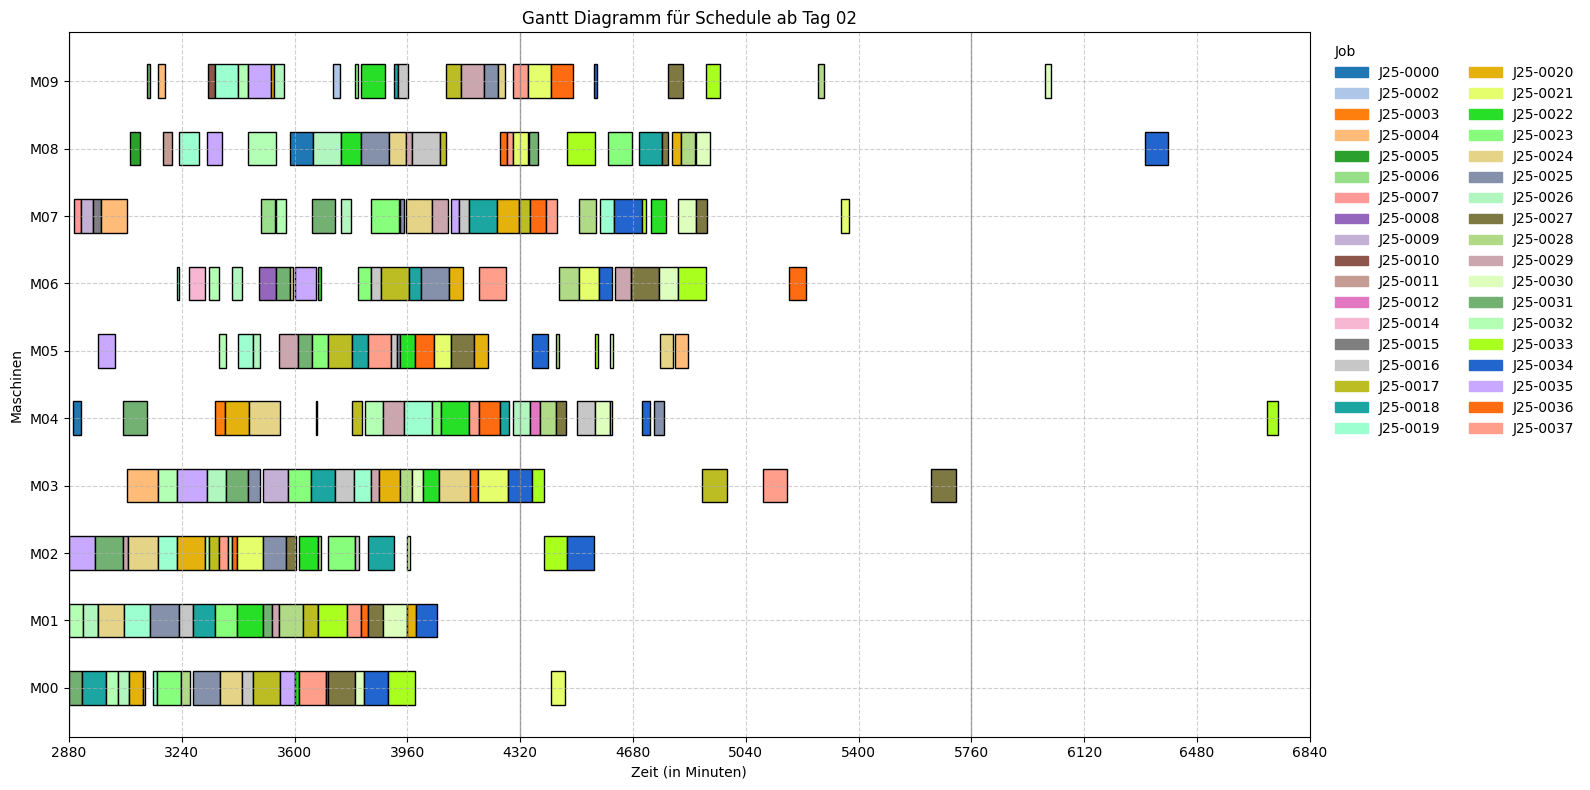

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

[Day 2 00:00:00] Job J25-0000, Operation 7 resumed with 12.00 min
[Day 2 00:00:00] Job J25-0012, Operation 8 resumed with 29.00 min
[Day 2 00:00:00] Job J25-0004, Operation 5 resumed with 42.00 min
[Day 2 00:00:00] Job J25-0031 started on M00
[Day 2 00:00:00] Job J25-0032 started on M01
[Day 2 00:00:00] Job J25-0035 started on M02
[Day 2 00:12:00] Job J25-0000 finished on M07 (after 12 minutes)
[Day 2 00:12:00] Job J25-0000 started on M04
[Day 2 00:15:00] Job J25-0007 started on M07
[Day 2 00:29:00] Job J25-0012 finished on M09 (after 29 minutes)
[Day 2 00:42:00] Job J25-0004 finished on M08 (after 42 minutes)
[Day 2 00:42:00] Job J25-0000 finished on M04 (after 30 minutes)
[Day 2 00:42:00] Job J25-0007 finished on M07 (after 27 minutes)

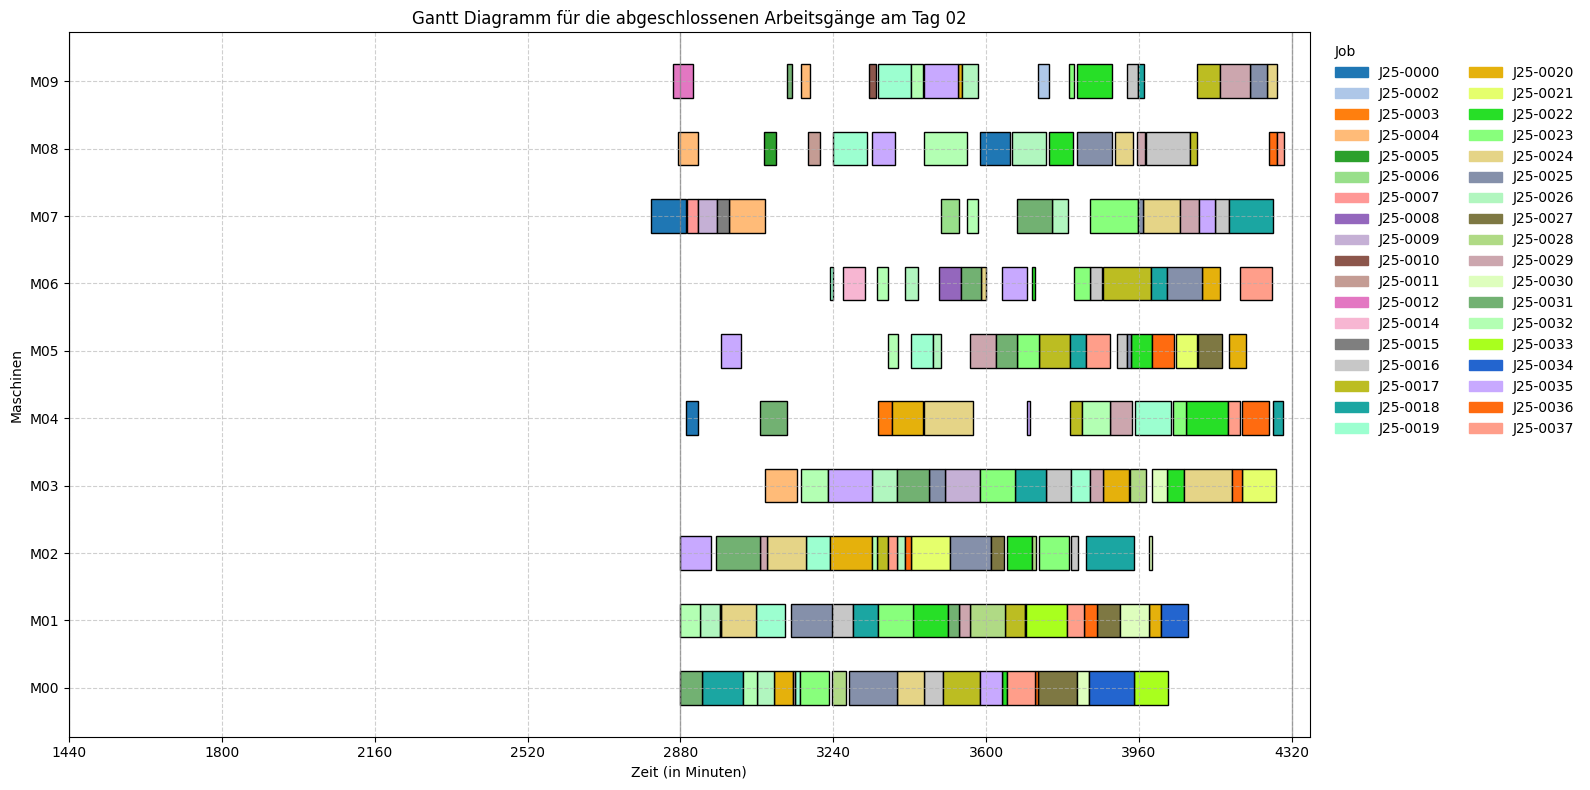

Tag 03: [4320, 5760)

Solver-Status         : FEASIBLE
Objective Value       : 199190.00
Best Objective Bound  : 174820.00
Laufzeit              : 1200.37 Sekunden
Deviation terms       : 57


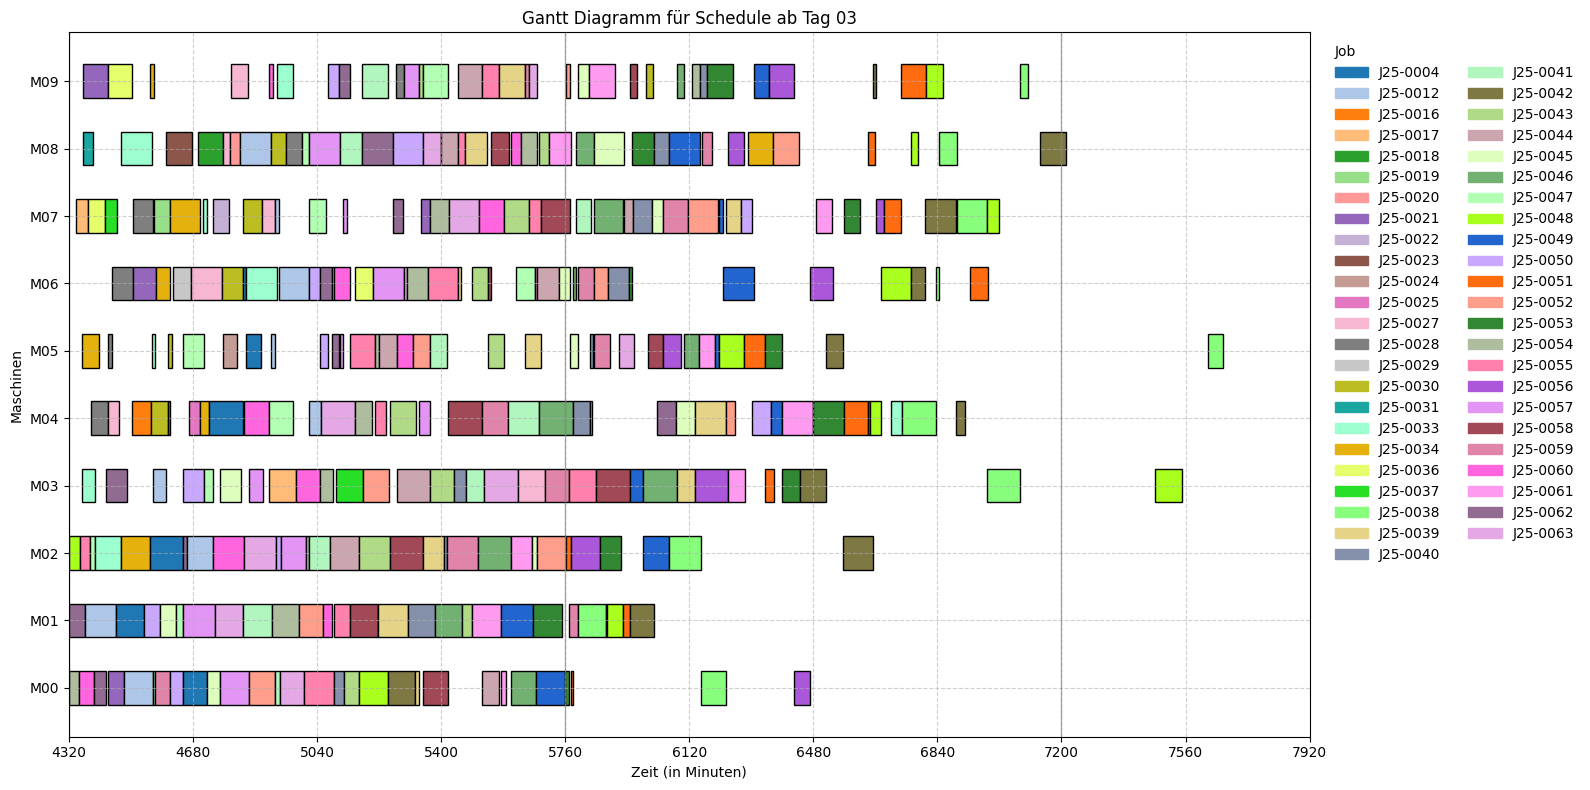

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

[Day 3 00:00:00] Job J25-0020, Operation 8 resumed with 20.00 min
[Day 3 00:00:00] Job J25-0034, Operation 2 resumed with 11.00 min
[Day 3 00:00:00] Job J25-0026, Operation 9 resumed with 22.00 min
[Day 3 00:00:00] Job J25-0021, Operation 4 resumed with 40.00 min
[Day 3 00:00:00] Job J25-0037, Operation 7 resumed with 39.00 min
[Day 3 00:00:00] Job J25-0048 started on M02
[Day 3 00:00:00] Job J25-0054 started on M00
[Day 3 00:00:00] Job J25-0062 started on M01
[Day 3 00:11:00] Job J25-0034 finished on M03 (after 11 minutes)
[Day 3 00:20:00] Job J25-0020 finished on M07 (after 20 minutes)
[Day 3 00:20:00] Job J25-0017 started on M07
[Day 3 00:22:00] Job J25-0026 finished on M04 (after 22 minutes)
[Day 3 00:26:00] Job J25-0048 finished on 

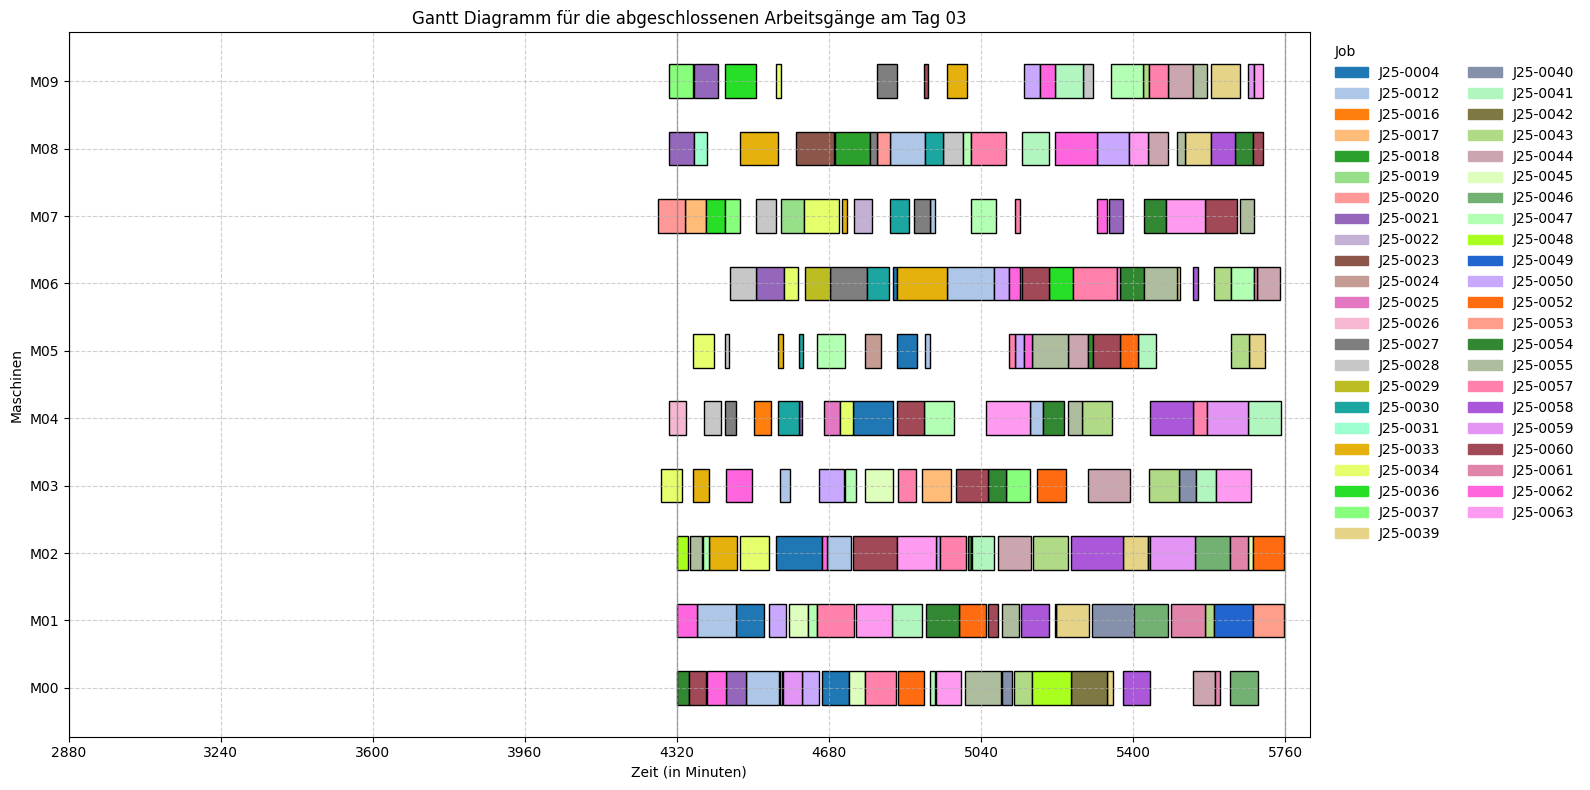

In [12]:
first_start = 2
last_planning_start = 3

for day_numb in range(first_start, last_planning_start + 1):
    day_start = day_length * day_numb
    day_end = day_start + day_length
    print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

    df_jobs_times_current = get_current_jobs(df_jobs_times, df_not_started, ready_time=day_start)

    df_jssp_current = filter_current_jssp(
       df_jssp=df_jssp,
       df_jobs_times_current=df_jobs_times_current,
       exclusion_dataframes_list=[df_active, df_execution]
    )

    # --- Scheduling ---
    df_schedule = cp_late_reschedule.solve_jssp_by_tardiness_and_earliness_with_devpen(
        df_jssp = df_jssp_current, df_times = df_jobs_times_current,
        df_original_plan= df_schedule, df_active= df_active,
        reschedule_start = day_start, w_t = 5,
        r = 0.30,                                           # 30% Flowtime, 70% Abweichung
        msg=False, timeLimit=max_time, gapRel= 0.02
    )

    df_schedule.to_csv(experiments_data_path / f"CP_{day_numb:02d}_schedule_{scheduling_type}.csv", index=False)
    show.plot_gantt(df_schedule, perspective="Machine", title=f"Gantt Diagramm für Schedule ab Tag {day_numb:02d}")
    check.all_in_one(df_schedule)

    # --- Simulation ---
    simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time = day_end)

    df_execution = simulation.get_finished_operations_df()
    show.plot_gantt(df_execution, perspective="Machine", title=f"Gantt Diagramm für die abgeschlossenen Arbeitsgänge am Tag {day_numb:02d}")

    df_active = simulation.get_active_operations_df()
    df_not_started = simulation.get_not_started_operations_df(df_schedule)

    # Extra
    execution_dict[day_numb] = df_execution

